In [82]:
import numpy as np # linear algebra
import pandas as pd # data processing
import tensorflow as tf
from nltk.corpus import stopwords
import keras.backend as K
from keras.models import Sequential
import string
import re

from tensorflow.keras.preprocessing import sequence
from sklearn.datasets import fetch_20newsgroups
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense,Input,Embedding,Dropout,Conv1D,MaxPooling1D,GlobalMaxPooling1D,Dropout,Bidirectional,Flatten,BatchNormalization,SimpleRNN,LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
#import transformers
#import tokenizers

from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
from transformers import pipeline

from sklearn.metrics import accuracy_score
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [83]:
DATASET_COLUMNS=['target','ids','date','flag','user','text']
DATASET_ENCODING = "ISO-8859-1"
data = pd.read_csv("training.1600000.processed.noemoticon.csv",encoding=DATASET_ENCODING, names=DATASET_COLUMNS)
data.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [84]:
print('length of data is', len(data))

length of data is 1600000


In [85]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [86]:
data.isna().sum()

target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64

In [87]:
data.target.value_counts()

0    800000
4    800000
Name: target, dtype: int64

In [88]:
data['target'] = data['target'].replace(4,1)
data=data[['text','target']]
data.target.value_counts()

0    800000
1    800000
Name: target, dtype: int64

In [89]:
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

STOPWORDS = set(stopwordlist)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

def clean_text(s):
    s = re.sub(r'http\S+', '', s)
    s = re.sub('(RT|via)((?:\\b\\W*@\\w+)+)', ' ', s)
    s = re.sub(r'@\S+', '', s)
    s = re.sub('&amp', ' ', s)
    return s

data['text'] = data['text'].apply(lambda text: cleaning_stopwords(text))
data['text'].head()
data['text'] = data['text'].apply(clean_text)

In [90]:
#Train test split
x=data.text
y=data.target

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y,
    test_size=0.05, shuffle = True, random_state = 8)

# Use the same function above for the validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state= 8)

In [91]:
X_test_df = pd.DataFrame(X_test) #for vader and transformer

In [92]:
#tokenize
max_features = 40000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))
X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(X_test)

In [93]:
#sequencing for lstm
max_words = 100
X_train = sequence.pad_sequences(X_train, maxlen=max_words, padding = 'post')
X_val = sequence.pad_sequences(X_val, maxlen=max_words, padding = 'post')
X_test = sequence.pad_sequences(X_test, maxlen=max_words, padding = 'post')

In [94]:
#Evaluating proper format and shape
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)
print(X_train.shape,X_val.shape, X_test.shape)

(1368000, 100) (152000, 100) (80000, 100)


In [95]:
model = Sequential()
model.add(Embedding(40000, 10, input_length=X_train.shape[1]))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 100, 10)           400000    
                                                                 
 conv1d_5 (Conv1D)           (None, 100, 32)           992       
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 50, 32)           0         
 1D)                                                             
                                                                 
 conv1d_6 (Conv1D)           (None, 50, 32)            3104      
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 25, 32)           0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 25, 32)           

In [96]:
model.fit(X_train, y_train, validation_data=(X_val,y_val), epochs=3, batch_size=256, verbose=1)

Epoch 1/3
5344/5344 [==============================] - 207s 38ms/step - loss: 0.4296 - accuracy: 0.8003 - val_loss: 0.4069 - val_accuracy: 0.8144
Epoch 2/3
5344/5344 [==============================] - 183s 34ms/step - loss: 0.3863 - accuracy: 0.8259 - val_loss: 0.4042 - val_accuracy: 0.8150
Epoch 3/3
5344/5344 [==============================] - 177s 33ms/step - loss: 0.3676 - accuracy: 0.8359 - val_loss: 0.4074 - val_accuracy: 0.8148


In [97]:
result = model.evaluate(X_test,y_test)
result

2500/2500 [==============================] - 5s 2ms/step - loss: 0.4064 - accuracy: 0.8160


[0.4063975512981415, 0.8160499930381775]

In [98]:
import nltk

In [99]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Anindya\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [100]:
sia = SentimentIntensityAnalyzer()

sia.polarity_scores("Performing good in sentiment analysis")

{'neg': 0.0, 'neu': 0.58, 'pos': 0.42, 'compound': 0.4404}

In [101]:
pip install ipywidgets

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [102]:
vaders = []
for i, row in tqdm(X_test_df.iterrows(), total = len(X_test_df)):
    vaders.append(sia.polarity_scores(row['text'])['compound'])
vaders = np.array(vaders)
vaders

  0%|          | 0/80000 [00:00<?, ?it/s]

array([ 0.7717,  0.    ,  0.9531, ...,  0.918 , -0.6705, -0.8185])

In [103]:
vaders = []
for i, row in tqdm(X_test_df.iterrows(), total = len(X_test_df)):
    vaders.append(sia.polarity_scores(row['text'])['compound'])
vaders = np.array(vaders)
vaders

  0%|          | 0/80000 [00:00<?, ?it/s]

array([ 0.7717,  0.    ,  0.9531, ...,  0.918 , -0.6705, -0.8185])

In [110]:
vaders_accuracy = accuracy_score(y_test,vaders)*100
print('Accuracy: ',vaders_accuracy, '%')

ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [104]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, vaders)*100
print('Mean Squared Error: ', mse)

Mean Squared Error:  40.2980938181125


In [105]:
pipe = pipeline("sentiment-analysis")

pipe('Performing good in sentiment analysis')

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


[{'label': 'POSITIVE', 'score': 0.9996926784515381}]

In [106]:
tp = []
for i, row in tqdm(X_test_df.iterrows(), total = len(X_test_df)):
    dict = pipe(row['text'])
    tp.append(dict[0].get('label'))

  0%|          | 0/80000 [00:00<?, ?it/s]

In [107]:
tp = np.array(tp)
tp = np.where(tp == "POSITIVE",1,0)
np.unique(tp, return_counts = True)

(array([0, 1]), array([46371, 33629], dtype=int64))

In [108]:
tf_accuracy = accuracy_score(y_test,tp)*100
print('Accuracy: ', tf_accuracy, '%')

Accuracy:  70.9375 %


<Axes: >

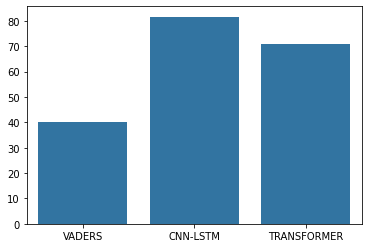

In [109]:
#Comparing
models = ['VADERS', 'CNN-LSTM', 'TRANSFORMER']
acc = [mse, result[1]*100,tf_accuracy]

sns.barplot(x = models, y = acc)